In [9]:
from stable_baselines3 import PPO
import numpy as np
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from ot2_env_wrapper import OT2Env  # Custom environment wrapper
from clearml import Task  # Import ClearML's Task
import typing_extensions


# Paths to your trained models
model_paths = [
     r"C:\Users\Edopi\Desktop\VirtualMLP\models\ksnfka60\model.zip",
     r"C:\Users\Edopi\Desktop\VirtualMLP\models\06lqnlgo\model.zip",
     r"C:\Users\Edopi\Desktop\VirtualMLP\models\8nwi2fpk\model.zip",
      r"C:\Users\Edopi\Desktop\VirtualMLP\models\8102npc5\model.zip",
    r"C:\Users\Edopi\Desktop\VirtualMLP\models\rg8hfw19\model.zip",
    r"C:\Users\Edopi\Desktop\VirtualMLP\models\z4sevf4e\model.zip",
 ]


def evaluate_model_fixed_goal(model_path, env, fixed_goal, num_episodes=10):
    model = PPO.load(model_path)  # Load the model
    accuracies, steps_taken = [], []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        env.goal_position = fixed_goal  # Override the goal position

        done, truncated = False, False
        step_count = 0

        while not done and not truncated:
            action, _ = model.predict(obs)
            obs, reward, done, truncated, info = env.step(action)
            step_count += 1

            # Calculate distance to the fixed goal
            distance_to_goal = np.linalg.norm(obs[:3] - fixed_goal)

            if done or truncated:
                accuracies.append(distance_to_goal)
                steps_taken.append(step_count)

    # Compute average and standard deviation of results
    avg_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    avg_steps = np.mean(steps_taken)

    return avg_accuracy, std_accuracy, avg_steps



def main():
    """
    Main function to evaluate all models with a fixed goal position.
    """
    fixed_goal_position = np.array([0.1, 0.1, 0.2], dtype=np.float32)  # Define fixed goal

    # Create the environment
    env = OT2Env(render=True, max_steps=1000)

    # Dictionary to store results
    results = {}

    # Evaluate each model
    for model_path in model_paths:
        print(f"Evaluating model: {model_path} with fixed goal {fixed_goal_position}")
        avg_accuracy, std_accuracy, avg_steps = evaluate_model_fixed_goal(
            model_path, env, fixed_goal_position
        )
        results[model_path] = {
            "avg_accuracy": avg_accuracy,
            "std_accuracy": std_accuracy,
            "avg_steps": avg_steps,
        }
        print(
            f"Model: {model_path} | Avg Accuracy: {avg_accuracy:.4f} m | "
            f"Std Dev: {std_accuracy:.4f} m | Avg Steps: {avg_steps:.2f}"
        )

    # Identify the best model based on accuracy
    best_model = min(results, key=lambda x: results[x]["avg_accuracy"])
    print(f"\nBest Model: {best_model}")
    print(
        f"Performance: Avg Accuracy = {results[best_model]['avg_accuracy']:.4f} m, "
        f"Std Dev = {results[best_model]['std_accuracy']:.4f} m, "
        f"Avg Steps = {results[best_model]['avg_steps']:.2f}"
    )

    # Close the environment
    env.close()


if __name__ == "__main__":
    main()


Evaluating model: C:\Users\Edopi\Desktop\VirtualMLP\models\ksnfka60\model.zip with fixed goal [0.1 0.1 0.2]
Reset: Pipette Position [0.073  0.0895 0.1195], Goal Position [ 0.09660532 -0.0709065   0.17827128]
Step 1 called with action: [-0.71239215 -0.29936796 -1.        ]
Step 2 called with action: [-0.4083809   0.34708256  0.58112097]
Step 3 called with action: [-0.2595161   1.          0.35826126]
Step 4 called with action: [0.5072443  0.30496833 0.38313666]
Step 5 called with action: [-0.34010354  0.37826392  0.28604096]
Step 6 called with action: [ 0.38736528 -0.20516185  0.45605063]
Step 7 called with action: [-0.68150294  1.         -0.4016276 ]
Step 8 called with action: [-0.7428623  1.         0.4008845]
Step 9 called with action: [-0.86597043  0.7108671   1.        ]
Step 10 called with action: [ 0.32121113 -1.         -0.9902249 ]
Step 11 called with action: [-0.02179879 -0.6569127  -0.4649546 ]
Step 12 called with action: [0.657657  0.5528625 1.       ]
Step 13 called with a

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from ot2_env_wrapper import OT2Env  # Ensure this is your custom environment wrapper
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# Paths to your trained models
model_paths = [
    r"C:\Users\Edopi\Desktop\VirtualMLP\models\ksnfka60\model.zip",
    r"C:\Users\Edopi\Desktop\VirtualMLP\models\06lqnlgo\model.zip",
    r"C:\Users\Edopi\Desktop\VirtualMLP\models\8nwi2fpk\model.zip",
    r"C:\Users\Edopi\Desktop\VirtualMLP\models\8102npc5\model.zip",
    r"C:\Users\Edopi\Desktop\VirtualMLP\models\rg8hfw19\model.zip",
    r"C:\Users\Edopi\Desktop\VirtualMLP\models\z4sevf4e\model.zip",
]

# Fixed goal position for all evaluations
fixed_goal_position = np.array([0.1, 0.1, 0.2], dtype=np.float32)

def evaluate_model_with_visualization(model_path, env, fixed_goal, num_episodes=5):
    model = PPO.load(model_path)  # Load the model

    for episode in range(num_episodes):
        obs, _ = env.reset()
        env.goal_position = fixed_goal  # Set the fixed goal position

        terminated, truncated = False, False
        positions = []  # To log pipette positions
        errors = []  # To log error distances
        rewards = []  # To log rewards
        steps = 0

        while not (terminated or truncated):
            # Current pipette position
            current_position = obs[:3]
            
            # Record position
            positions.append(current_position)

            # Compute error
            error = np.linalg.norm(current_position - fixed_goal)
            errors.append(error)

            # Predict action
            action, _ = model.predict(obs)

            # Step the environment
            obs, reward, terminated, truncated, _ = env.step(action)

            # Record reward
            rewards.append(reward)
            steps += 1

            # Check if the goal is reached within a tolerance
            if error < 0.001: # 10 mm tolerance
                print(f"Goal reached within tolerance at step {steps}.")
                terminated = True

        # Visualization
        positions = np.array(positions)
        errors = np.array(errors)

        plt.figure(figsize=(12, 6))

        # Plot 3D position over time
        plt.subplot(1, 2, 1)
        plt.plot(positions[:, 0], label='X')
        plt.plot(positions[:, 1], label='Y')
        plt.plot(positions[:, 2], label='Z')
        plt.title("Pipette Position Over Time")
        plt.xlabel("Steps")
        plt.ylabel("Position (m)")
        plt.legend()
        plt.grid()

        # Plot error over time
        plt.subplot(1, 2, 2)
        plt.plot(errors, label='Error')
        plt.title("Error Over Time")
        plt.xlabel("Steps")
        plt.ylabel("Error (m)")
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

        print(f"Model: {model_path} | Steps: {steps} | Final Error: {errors[-1]:.4f} m")

def main():
    # Create the environment
    env = OT2Env(render=True, max_steps=2000)

    for model_path in model_paths:
        print(f"Evaluating model: {model_path} with fixed goal {fixed_goal_position}")
        evaluate_model_with_visualization(model_path, env, fixed_goal_position)

    # Close the environment
    env.close()

if __name__ == "__main__":
    main()


Evaluating model: C:\Users\Edopi\Desktop\VirtualMLP\models\ksnfka60\model.zip with fixed goal [0.1 0.1 0.2]


Evaluating model: z4sevf4e with fixed goal [0.1 0.1 0.2]
Reset: Pipette Position [0.073  0.0895 0.1195], Goal Position [ 0.02599333 -0.13415097  0.2419774 ]
Step 1 called with action: [-4.7792052e-04 -5.2740663e-01 -1.0000000e+00]
Step 2 called with action: [-0.27631044  1.         -0.6090721 ]
Step 3 called with action: [ 0.6315966  -0.46013254  0.5412778 ]
Step 4 called with action: [ 0.93152016 -1.          0.87815964]
Step 5 called with action: [-0.1970128  1.        -1.       ]
Step 6 called with action: [-1.          0.7899796   0.35766855]
Step 7 called with action: [-0.5088365 -1.         1.       ]
Step 8 called with action: [-0.82462037 -0.6835864  -0.00760265]
Step 9 called with action: [-0.514574    0.00217585  1.        ]
Step 10 called with action: [-1.         -0.3874372   0.29032165]
Step 11 called with action: [-0.1207016  1.        -0.6221642]
Step 12 called with action: [ 0.9703135  -0.5386923   0.68826216]
Step 13 called with action: [ 0.15825784 -0.32135755 -0.5747

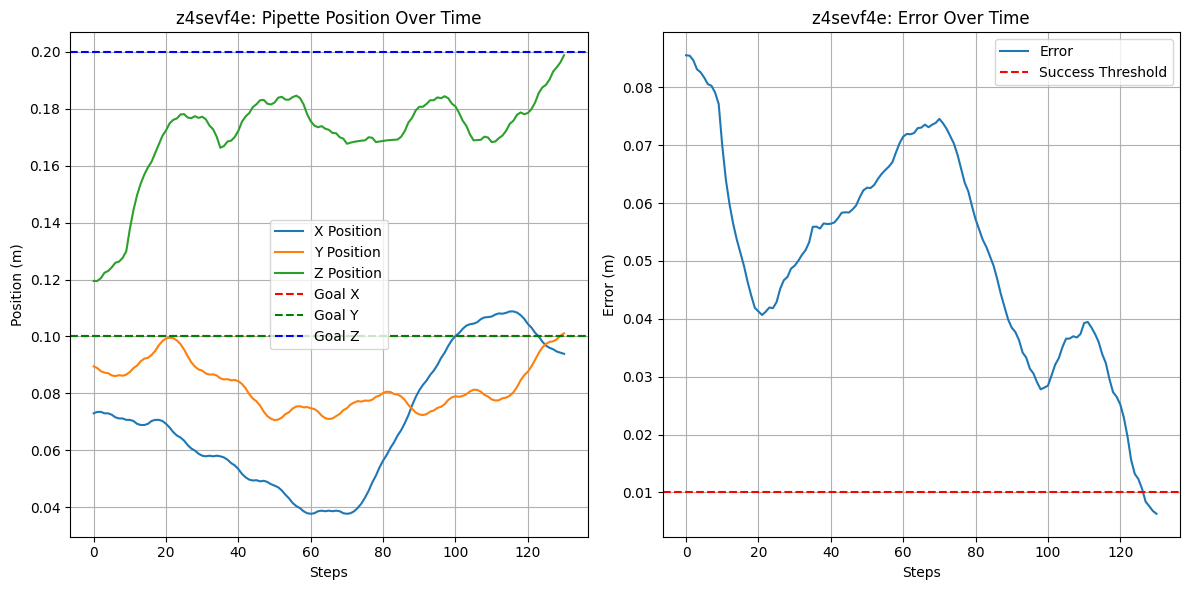

Evaluating model: Downloads with fixed goal [0.1 0.1 0.2]
Reset: Pipette Position [0.073  0.0895 0.1195], Goal Position [0.00149937 0.10426567 0.21497028]
Step 1 called with action: [-1.         -0.24453071  1.        ]
Step 2 called with action: [ 0.33636868 -0.01618418  1.        ]
Step 3 called with action: [0.8075111  0.09742625 1.        ]
Step 4 called with action: [-0.07576698  0.06850421  1.        ]
Step 5 called with action: [ 1.         -0.09023763  1.        ]
Step 6 called with action: [ 0.4015305  -0.15801579  0.9760364 ]
Step 7 called with action: [0.5456471 0.5969629 1.       ]
Step 8 called with action: [0.4524008  0.12839326 1.        ]
Step 9 called with action: [0.55089784 0.30373564 1.        ]
Step 10 called with action: [0.474063   0.26275897 0.6093419 ]
Step 11 called with action: [0.7059528  0.02652889 1.        ]
Step 12 called with action: [ 0.19323117 -0.09771802  0.74875927]
Step 13 called with action: [0.2944059  0.30542693 0.98937917]
Step 14 called with 

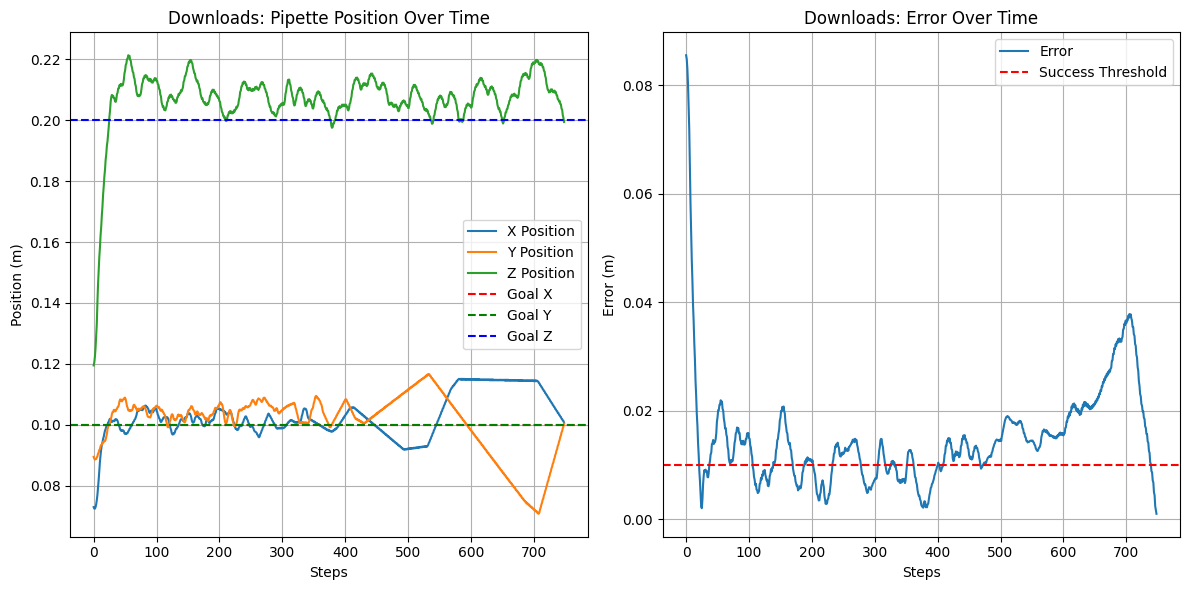

Evaluating model: Task11 with fixed goal [0.1 0.1 0.2]
Reset: Pipette Position [0.073  0.0895 0.1195], Goal Position [0.181827   0.11737994 0.21686552]
Step 1 called with action: [1.        0.6678062 1.       ]
Step 2 called with action: [0.03212675 0.52343833 1.        ]
Step 3 called with action: [0.47052574 0.6113212  1.        ]
Step 4 called with action: [-0.06581482 -0.5431553   1.        ]
Step 5 called with action: [0.29508686 0.7067634  1.        ]
Step 6 called with action: [ 0.500798   -0.12422743  1.        ]
Step 7 called with action: [-0.05363783  0.54650426  1.        ]
Step 8 called with action: [0.6810971 0.5339165 1.       ]
Step 9 called with action: [0.45886743 0.33273    1.        ]
Step 10 called with action: [ 1.        -0.5254208  1.       ]
Step 11 called with action: [0.2721938  0.15778127 1.        ]
Step 12 called with action: [0.24909922 0.03976519 0.90544325]
Step 13 called with action: [0.60555184 0.01343567 1.        ]
Step 14 called with action: [0.2365

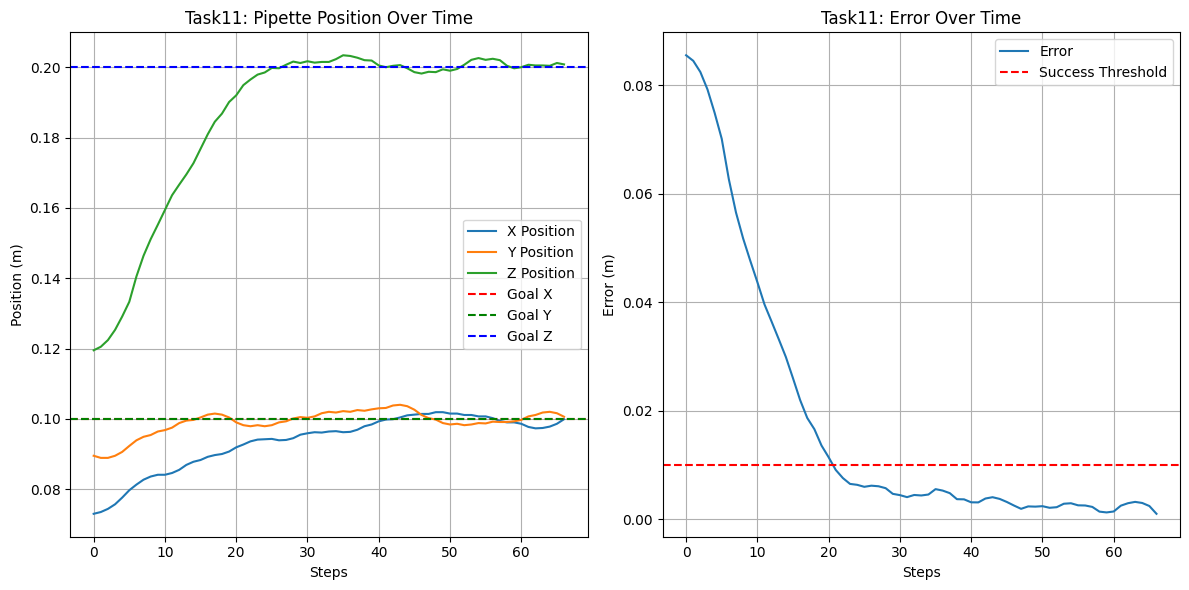


Best Model: Task11
Lowest Error: 0.001005 m
Closing environment.


In [2]:
from stable_baselines3 import PPO
import numpy as np
import matplotlib.pyplot as plt
import os
from ot2_env_wrapper import OT2Env  # Your custom environment wrapper
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Paths to your trained models
model_paths = [
    r"C:\Users\Edopi\Desktop\VirtualMLP\models\z4sevf4e\model.zip",
    r"C:\Users\Edopi\Downloads\model (6).zip",
    r"C:\Users\Edopi\Desktop\2024-25b-fai2-adsai-EdoardoPierezza231412\datalab_tasks\Task11\model (7).zip",
]


def evaluate_model_visualize(model_path, env, fixed_goal, num_episodes=10):
    """
    Evaluate a trained RL model, find the lowest error run, and visualize it.

    Args:
        model_path (str): Path to the trained model.
        env (gym.Env): The environment to test on.
        fixed_goal (np.array): Fixed goal position for evaluation.
        num_episodes (int): Number of episodes to test.

    Returns:
        tuple: (lowest_error, best_run_positions, best_run_errors)
    """
    model = PPO.load(model_path)  # Load the model
    lowest_error = float('inf')  # Initialize the lowest error
    best_run_positions = []  # To store the positions for the best run
    best_run_errors = []  # To store the errors for the best run

    for episode in range(num_episodes):
        obs, _ = env.reset()
        env.goal_position = fixed_goal  # Set fixed goal position

        done = False
        positions = []
        errors = []

        while not done:
            # Current pipette position
            current_position = obs[:3]
            positions.append(current_position)

            # Calculate the error (distance to the goal)
            distance_to_goal = np.linalg.norm(current_position - fixed_goal)
            errors.append(distance_to_goal)

            # Update the lowest error and best run data
            if distance_to_goal < lowest_error:
                lowest_error = distance_to_goal
                best_run_positions = positions.copy()
                best_run_errors = errors.copy()

            # Predict action and step
            action, _ = model.predict(obs)
            obs, reward, done, truncated, info = env.step(action)

            if truncated:  # Break if max steps are reached
                break

    return lowest_error, best_run_positions, best_run_errors


def plot_visuals(model_name, positions, errors, goal):
    """
    Plot the 3D trajectory and error over time for the best run.

    Args:
        model_name (str): Name of the model.
        positions (list): Positions during the best run.
        errors (list): Errors during the best run.
        goal (np.array): Goal position.
    """
    positions = np.array(positions)

    # Plot 3D trajectory
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(positions[:, 0], label='X Position')
    plt.plot(positions[:, 1], label='Y Position')
    plt.plot(positions[:, 2], label='Z Position')
    plt.axhline(y=goal[0], color='r', linestyle='--', label='Goal X')
    plt.axhline(y=goal[1], color='g', linestyle='--', label='Goal Y')
    plt.axhline(y=goal[2], color='b', linestyle='--', label='Goal Z')
    plt.title(f"{model_name}: Pipette Position Over Time")
    plt.xlabel("Steps")
    plt.ylabel("Position (m)")
    plt.legend()
    plt.grid()

    # Plot error over time
    plt.subplot(1, 2, 2)
    plt.plot(errors, label='Error')
    plt.axhline(y=0.01, color='r', linestyle='--', label='Success Threshold')
    plt.title(f"{model_name}: Error Over Time")
    plt.xlabel("Steps")
    plt.ylabel("Error (m)")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


def main():
    """
    Main function to evaluate models, find the lowest error, and visualize the best run.
    """
    fixed_goal_position = np.array([0.1, 0.1, 0.2], dtype=np.float32)  # Define fixed goal

    # Create the environment
    env = OT2Env(render=True, max_steps=1000)

    # Dictionary to store the lowest errors for each model
    lowest_errors = {}

    for model_path in model_paths:
        model_name = model_path.split("\\")[-2]  # Extract model name
        print(f"Evaluating model: {model_name} with fixed goal {fixed_goal_position}")
        
        lowest_error, best_run_positions, best_run_errors = evaluate_model_visualize(
            model_path, env, fixed_goal_position
        )
        lowest_errors[model_name] = lowest_error
        print(f"Model: {model_name} | Lowest Error: {lowest_error:.6f} m")

        # Visualize the best run
        plot_visuals(model_name, best_run_positions, best_run_errors, fixed_goal_position)

    # Identify the best model (with the lowest error)
    best_model = min(lowest_errors, key=lowest_errors.get)
    print(f"\nBest Model: {best_model}")
    print(f"Lowest Error: {lowest_errors[best_model]:.6f} m")

    # Close the environment
    env.close()


if __name__ == "__main__":
    main()


In [ ]:
from stable_baselines3 import PPO
 
model_paths = [
    # r"C:\Users\Edopi\Desktop\VirtualMLP\models\ksnfka60\model.zip",
    # r"C:\Users\Edopi\Desktop\VirtualMLP\models\06lqnlgo\model.zip",
    # r"C:\Users\Edopi\Desktop\VirtualMLP\models\8nwi2fpk\model.zip",
    # r"C:\Users\Edopi\Desktop\VirtualMLP\models\8102npc5\model.zip",
    # r"C:\Users\Edopi\Desktop\VirtualMLP\models\rg8hfw19\model.zip",
    r"C:\Users\Edopi\Desktop\VirtualMLP\models\z4sevf4e\model.zip",
    r"C:\Users\Edopi\Downloads\model (6).zip",
    r"C:\Users\Edopi\Desktop\2024-25b-fai2-adsai-EdoardoPierezza231412\datalab_tasks\Task11\model (7).zip",
]
 
for model_path in model_paths:
    model = PPO.load(model_path)  # Load the model
   
    # Extract relevant hyperparameters
    hyperparams = {
        "learning_rate": model.learning_rate,
        "batch_size": model.batch_size,
        "n_steps": model.n_steps,
        "gamma": model.gamma,
        "gae_lambda": model.gae_lambda,
        "clip_range": model.clip_range,
        "ent_coef": model.ent_coef,
        "vf_coef": model.vf_coef,
        "max_grad_norm": model.max_grad_norm,
        "policy_kwargs": model.policy_kwargs,  # Policy architecture
    }
   
    print(f"\nHyperparameters for model: {model_path}")
    for key, value in hyperparams.items():
        print(f"{key}: {value}")


Hyperparameters for model: C:\Users\Edopi\Desktop\VirtualMLP\models\ksnfka60\model.zip
learning_rate: 0.0003
batch_size: 64
n_steps: 2048
gamma: 0.99
gae_lambda: 0.95
clip_range: <function get_schedule_fn.<locals>.<lambda> at 0x00000254CF47F1F0>
ent_coef: 0.0
vf_coef: 0.5
max_grad_norm: 0.5
policy_kwargs: {}

Hyperparameters for model: C:\Users\Edopi\Desktop\VirtualMLP\models\06lqnlgo\model.zip
learning_rate: 0.0003
batch_size: 64
n_steps: 2048
gamma: 0.99
gae_lambda: 0.95
clip_range: <function get_schedule_fn.<locals>.<lambda> at 0x00000254CF47F790>
ent_coef: 0.0
vf_coef: 0.5
max_grad_norm: 0.5
policy_kwargs: {}

Hyperparameters for model: C:\Users\Edopi\Desktop\VirtualMLP\models\8nwi2fpk\model.zip
learning_rate: 0.0003
batch_size: 64
n_steps: 2048
gamma: 0.99
gae_lambda: 0.95
clip_range: <function get_schedule_fn.<locals>.<lambda> at 0x00000254CF47F8B0>
ent_coef: 0.0
vf_coef: 0.5
max_grad_norm: 0.5
policy_kwargs: {}

Hyperparameters for model: C:\Users\Edopi\Desktop\VirtualMLP\model

| Model          | Learning Rate | Batch Size | Gamma | Lowest Error (m) | Comments |
|---------------|--------------|------------|-------|------------------|----------|
| Model (1) (Mussaed) | 0.0001 | 32  | 0.98  | 0.001025 | Small batch size, good performance |
| Model (2) (Mussaed) | 1e-05  | 64  | 0.98  | 0.009019 | Worst performance, learning rate too low |
| Model (3) (Mussaed) | 0.0001 | 32  | 0.98  | 0.001019 | Best model among Mussaed's |
| Model (4) (Mussaed) | 5e-05  | 128 | 0.999 | 0.001032 | High gamma, slightly larger error |
| Model (5) (Mussaed) | 0.0001 | 64  | 0.98  | 0.001047 | Similar to Model 3 but slightly worse |
| Model (6) (Mussaed) | 1e-05  | 128 | 0.96  | 0.002459 | Low learning rate, second-worst performance |
| Model (z4sevf4e) (Edoardo) | 0.0003 | 64  | 0.99 | 0.006313 | Much higher error than others |
| Model (Downloads) (Edoardo) | 0.0003 | 128 | 0.99 | 0.001005 | 2nd Best Model overall |
| Model (Task11) (Edoardo) | 0.0001 | 64  | 0.99 | 0.000954 | Best Model (Lowest Error) |
